<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="1000px"/><br>

----
# NIRSpec BOTS pipeline rerun
----

**Author**: Nikolay Nikolov, AURA Associate Scientist, NIRSpec branch
<br>
**Pipeline Version**: 1.13.4
<br>
**Last Update**: April 5, 2024

## <font color='white'>-</font>Table of contents<a class="anchor" id="table"></a>
1. [Introduction and setup](#intro)<br>
2. [Data download](#download)<br>
3. [Stage 1: Detector1Pipeline](#stage1)<br>
4. [Stage 2: Spec2Pipeline](#stage2)<br>
5. [Stage 3: Tso3Pipeline](#stage3)<br>
6. [Concluding remarks](#remarks)<br>

---

### 1.<font color='white'>-</font>Introduction and setup<a class="anchor" id="intro"></a>

---

Prior to performing data analysis, it is recommended that the user installs a fresh new version of the JWST pipeline in a separate environment. This can be done by running the commands bellow in your terminal:

`conda create -n <env_name> python=3.11`<br>
`conda activate <env_name>`<br>
`pip install jwst`<br>

In addition, one would need to install Jupyter Notebooks or Jupyter Lab using the pip install command inside the JWST environment to be able to open the notebook. Once this is done, open the notebook by executing:

`jupyter notebook BOTS_pipeline_rerun.ipynb`<br>
or <br>
`jupyter lab BOTS_pipeline_rerun.ipynb`<br>

The purpose of this notebook is to demonstrate how to re-run the three stages of the STScI pipeline for NIRSpec BOTS. At the time of creating this notebook, the pipeline continues to be improved. In order to deliver useful products for light curve analysis, this notebook provides a guidance to how to rerun the pipeline and also offsets a work around solution for the 1/f-noise clean step. Prior to performing data analysis, we import all the needed libraries and set up paths.


In [1]:
# General functions
import os
import time as tt


import shutil
import json

import numpy as np

# Multiprocessing functions
import multiprocessing as mp


# Astroquerry
# import astroquery
from astroquery.mast import Observations

# JWST Pipeline
import jwst
import crds
from jwst import datamodels
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Tso3Pipeline


# Plot functions
import matplotlib.pyplot as plt

# import pandas as pd
from astropy.table import Table

# %set_env CRDS_PATH /path/to/my/folder/
# %set_env CRDS_SERVER_URL https://jwst-crds.stsci.edu

print("JWST Calibration Pipeline Version={}".format(jwst.__version__))
print("Current Operational CRDS Context = {}".format(crds.get_default_context()))
print("Number of processors: ", mp.cpu_count())

JWST Calibration Pipeline Version=1.13.4
Current Operational CRDS Context = jwst_1223.pmap
Number of processors:  12


#### [Link to the Table of contents](#table)

---

### 2.<font color='white'>-</font>Data download <a class="anchor" id="download"></a>

---

The input data for this notebook is a transit of WASP-39b, observed in the BOTS G395H grism. The data set belongs to the <a href="https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1366">JWST Early Release Science program ERS-1366,</a> observation 3, and includes 456 integrations of 70 groups each with the SUB2048 subarray (array size of 2048 by 32 pixels per integration, per group), covering a total of 10.56 hours. The data set consists of three segments of `rateints` files, each with a size of 1.42 GB. 

Information of existing and planned JWST TSO programs of transiting exoplanets, including with the NIRSpec BOTS mode, can be obtained from <a href="https://www.stsci.edu/~nnikolov/TrExoLiSTS/JWST/trexolists.html">TrExoLiSTS</a>

In [2]:
process_detector = "nrs1"  # choose 'nrs1', 'nrs2'

# Define the rateints files (aka slope or rate images)
if process_detector == "nrs1":
    files = [
        "jw01366003001_04101_00001-seg001_nrs1_uncal.fits",
        "jw01366003001_04101_00001-seg002_nrs1_uncal.fits",
        "jw01366003001_04101_00001-seg003_nrs1_uncal.fits",
    ]

if process_detector == "nrs2":
    files = [
        "jw01366003001_04101_00001-seg001_nrs2_uncal.fits",
        "jw01366003001_04101_00001-seg002_nrs2_uncal.fits",
        "jw01366003001_04101_00001-seg003_nrs2_uncal.fits",
    ]

asn_spec3_file = "jw01366-o003_20230901t213306_tso3_00001_asn.json"

In [3]:
# Extract rootnames. We will use these to determine which file names to be analyzed
froot = [files[i].replace("uncal.fits", "") for i in range(len(files))]
print(froot)

['jw01366003001_04101_00001-seg001_nrs1_', 'jw01366003001_04101_00001-seg002_nrs1_', 'jw01366003001_04101_00001-seg003_nrs1_']


Next, the notebook will create folder structure for the data and pipeline products from the three stages. When the notebook is run for the first time, it will also download the data and put it in the  data directory. Data download will be skipped, if the data directory with files already exists.

In [4]:
working_dir = os.getcwd() + "/"

data_dir = working_dir + "data/"
stage1_dir = working_dir + "stage1/"
stage2_dir = working_dir + "stage2/"
stage3_dir = working_dir + "stage3/"


if not os.path.exists(data_dir):
    print("Creating " + data_dir + " ...")
    os.makedirs(data_dir)

if not os.path.exists(stage1_dir):
    print("Creating " + stage1_dir + " ...")
    os.makedirs(stage1_dir)

if not os.path.exists(stage2_dir):
    print("Creating " + stage2_dir + " ...")
    os.makedirs(stage2_dir)

if not os.path.exists(stage3_dir):
    print("Creating " + stage3_dir + " ...")
    os.makedirs(stage3_dir)


# Download the uncal files, if not currently present
mast_dir = "mast:jwst/product"
for i in range(len(files)):
    if os.path.isfile(data_dir + files[i]):
        print("Uncal files found in the data directory. Not downloading ...")
    if not os.path.isfile(data_dir + files[i]):
        print("Uncal files missing in the data directory. Now downloading ...")
        mast_path = os.path.join(mast_dir, files[i])
        local_path = os.path.join(data_dir, files[i])
        Observations.download_file(mast_path, cache=False)
        shutil.move(working_dir + files[i], data_dir)

if not os.path.isfile(stage2_dir + asn_spec3_file):
    print(
        "TSO3 association file is missing in the stage2 directory. Now downloading ..."
    )
    mast_path = os.path.join(mast_dir, asn_spec3_file)
    local_path = os.path.join(stage2_dir, asn_spec3_file)
    Observations.download_file(mast_path, cache=False)
    shutil.move(working_dir + asn_spec3_file, stage2_dir)

Creating /Users/nnikolov/Documents/Functional/NIRSpec/Pipeline_testing/20231211_NB_for_MClarke/data/ ...
Creating /Users/nnikolov/Documents/Functional/NIRSpec/Pipeline_testing/20231211_NB_for_MClarke/stage1/ ...
Creating /Users/nnikolov/Documents/Functional/NIRSpec/Pipeline_testing/20231211_NB_for_MClarke/stage2/ ...
Creating /Users/nnikolov/Documents/Functional/NIRSpec/Pipeline_testing/20231211_NB_for_MClarke/stage3/ ...
Uncal files missing in the data directory. Now downloading ...
Uncal files missing in the data directory. Now downloading ...
Uncal files missing in the data directory. Now downloading ...
TSO3 association file is missing in the stage2 directory. Now downloading ...


#### [Link to the Table of contents](#table)
#### [Link to Data download](#download), [Link to Stage2](#stage2), [Link to Stage3](#stage3)

---
### <font color='white'>-</font>Stage 1: Detector1Pipeline<a class="anchor" id="stage1"></a>

---

This step applies basic detector-level corrections to all exposure types, and it is seldom referred as 'ramps-to-slopes' processing. For more information regarding the individual steps applied on NIRSpec BOTS data, please consult: <a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html">calwebb_detector1: Stage 1 Detector Processing.</a>

First, define a dictionary with all steps included by default for BOTS, and include parameters accordingly. To perform or skip a step in the pipeline, one specifies the attribute `skip` in the parameter dictionary and assigns a value `False` for executing, or `True` for skipping the step. 

This step takes approximately 17 minutes for the three segments of the NRS1 detector.

In [6]:
param_stage1 = {
    "group_scale": {"skip": False},
    "dq_init": {"skip": False},
    "saturation": {"skip": False},
    "superbias": {"skip": False},
    "refpix": {"skip": False},
    "linearity": {"skip": False},
    "dark_current": {"skip": False},
    "jump": {
        "skip": False,
        "maximum_cores": "half",  # ‘all’, ‘quarter’, 'eleven'
        "rejection_threshold": 4.0,
    },
    "ramp_fit": {"skip": False, "maximum_cores": "half"},
    "gain_scale": {"skip": False},
}

start = tt.time()

for i in range(len(files)):
    Detector1Pipeline.call(
        data_dir + files[i],
        save_results=True,
        steps=param_stage1,
        output_dir=stage1_dir,
    )

end = tt.time()
print("Run time: ", round(end - start, 1) / 60.0, " min")

2024-04-05 10:29:05,034 - CRDS - ERROR -  Error determining best reference for 'pars-emicorrstep'  =   Unknown reference type 'pars-emicorrstep'
2024-04-05 10:29:05,040 - CRDS - ERROR -  Error determining best reference for 'pars-chargemigrationstep'  =   Unknown reference type 'pars-chargemigrationstep'
2024-04-05 10:29:05,043 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/nnikolov/Documents/Functional/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0002.asdf
2024-04-05 10:29:05,052 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/nnikolov/Documents/Functional/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0003.asdf
2024-04-05 10:29:05,102 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2024-04-05 10:29:05,103 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2024-04-05 10:29:05,103 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance cre

Run time:  16.521666666666665  min


#### [Link to the Table of contents](#table)
#### [Link to Stage 1](#stage1), [Link to Stage 3](#stage3)

---

### <font color='white'>-</font>Stage 2: Spec2Pipeline <a class="anchor" id="stage2"></a>

---

The `Spec2Pipeline` performs additional instrumental corrections and calibrations to produce calibrated exposures. Details of the specific steps that need to be included for the BOTS mode are documented in the <a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html">calwebb_spec2: Stage 2 Spectroscopic Processing.</a> 

Prior to running the pipeline, we perform two modifications:
1. Remove 1/f noise
2. Modify the aperture size with which we will run the `extract_1d` step

JWST detector readout electronics (a.k.a. SIDECAR ASICs) generate significant 1/f noise during detector operations and signal digitization. When using NIRSpec BOTS, this 1/f noise appears as vertical banding that spans the entire width of the 2d spectral image, and varies from column to column. If not handled properly, the 1/f noise can introduce systematic errors and extra scatter in the light curves. For more information, please visit: <a href="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources#JWSTTimeSeriesObservationsNoiseSources-1/fnoise">JWST Time-Series Observations Noise Sources.</a>

The main pipeline algorithm for removal of 1/f-noise is called <a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/nsclean/index.html">NSClean</a> (<a href="https://ui.adsabs.harvard.edu/abs/2024PASP..136a5001R/abstract">Rauscher 2023</a>), and it is not run by default. An alternative solution is provided here by removal of 1/f-noise by subtracting the median background flux on a column-by-column basis. The function below performs this task.

In [7]:
def correct_one_over_f(image, b_low, b_high, detector_id):
    # Inputs:
    # image - image to correct, 2D array
    # blow - lower column pixels for the two regions, a tuple of two values
    # bhigh - higher column pixels for the two regions, a tuple of two values

    y_lo_1, y_lo_2 = b_low
    y_hi_1, y_hi_2 = b_high

    corrected_image = np.copy(image)
    for i in range(image.shape[1]):
        # print(image.shape[1])

        if detector_id == "nrs1":
            corrected_image[:, i] = image[:, i] - np.nanmedian(
                np.concatenate((image[y_lo_1:y_hi_1, i], image[y_lo_2:y_hi_2, i]))
            )

        if detector_id == "nrs2":
            if i <= 1250:
                corrected_image[:, i] = image[:, i] - np.nanmedian(
                    image[y_lo_1:y_hi_1, i]
                )
            if i > 1250:
                corrected_image[:, i] = image[:, i] - np.nanmedian(
                    image[y_lo_2:y_hi_2, i]
                )

    return corrected_image

We next specify the background region that the 1/f noise function will use for subtraction.

In [8]:
n_segments = len(froot)

if process_detector == "nrs1":
    b_low = (0, 26)
    b_high = (5, 31)

if process_detector == "nrs2":
    b_low = (26, 0)
    b_high = (31, 5)


for i in range(n_segments):
    print("\nRemoving 1/f, segment ", i + 1, " out of ", n_segments)
    ramp_HDUL = datamodels.open(stage1_dir + froot[i] + "rateints.fits")
    # ramp_HDUL.info() # this command prints the data model contents
    ramp_sci = ramp_HDUL.data

    corrected_1overf_2Dspec = np.copy(ramp_sci)
    for j in range(len(ramp_sci[:, 0, 0])):
        corrected_1overf_2Dspec[j, :, :] = correct_one_over_f(
            ramp_sci[j, :, :], b_low, b_high, process_detector
        )
    ramp_HDUL.data = corrected_1overf_2Dspec
    ramp_HDUL.save(
        stage1_dir + froot[i] + "rateints_1cl.fits"
    )  # add '1cl' suffix to indicate 1/f-cleaned 2D spectra
    ramp_HDUL.close()

2024-04-05 10:53:38,539 - stpipe - WARNING - /var/folders/k5/bfrtdtg92314p_l09pny5d7c0002hw/T/ipykernel_77164/1607684194.py:15: RuntimeWarning: All-NaN slice encountered
2024-04-05 10:53:38,539 - stpipe - WARNING -   corrected_image[:, i] = image[:, i] - np.nanmedian( np.concatenate((image[y_lo_1:y_hi_1,i],image[y_lo_2:y_hi_2,i])) )
2024-04-05 10:53:38,540 - stpipe - WARNING - 



Removing 1overf noise from segment  1  out of  3


2024-04-05 10:53:44,286 - stpipe - WARNING - /var/folders/k5/bfrtdtg92314p_l09pny5d7c0002hw/T/ipykernel_77164/1607684194.py:15: RuntimeWarning: All-NaN slice encountered
2024-04-05 10:53:44,286 - stpipe - WARNING -   corrected_image[:, i] = image[:, i] - np.nanmedian( np.concatenate((image[y_lo_1:y_hi_1,i],image[y_lo_2:y_hi_2,i])) )
2024-04-05 10:53:44,287 - stpipe - WARNING - 



Removing 1overf noise from segment  2  out of  3


2024-04-05 10:53:50,069 - stpipe - WARNING - /var/folders/k5/bfrtdtg92314p_l09pny5d7c0002hw/T/ipykernel_77164/1607684194.py:15: RuntimeWarning: All-NaN slice encountered
2024-04-05 10:53:50,069 - stpipe - WARNING -   corrected_image[:, i] = image[:, i] - np.nanmedian( np.concatenate((image[y_lo_1:y_hi_1,i],image[y_lo_2:y_hi_2,i])) )
2024-04-05 10:53:50,069 - stpipe - WARNING - 



Removing 1overf noise from segment  3  out of  3


Next, we can plot the uncorrected versus 1/f-corrected image, as well as their difference, and visually inspect it for residual signal. 

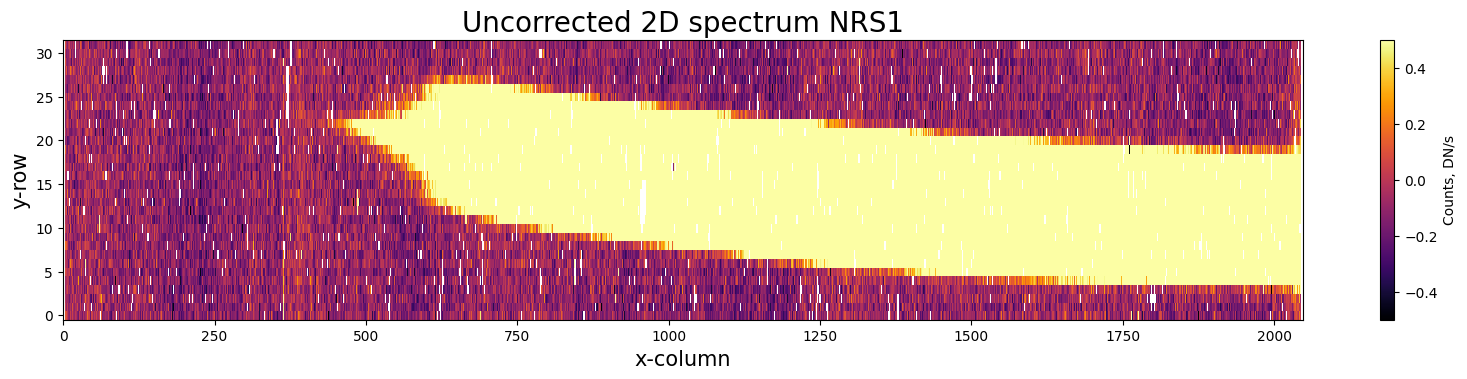

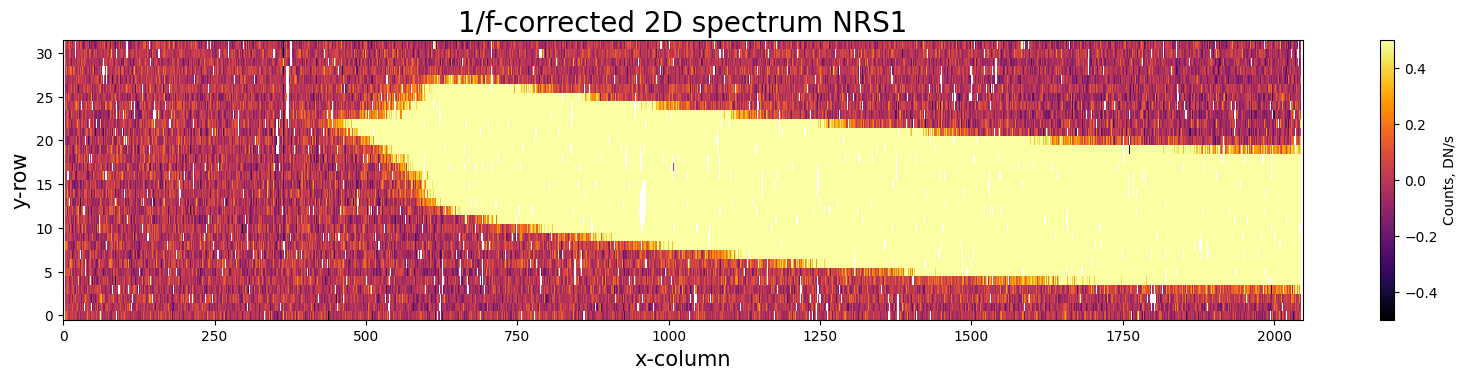

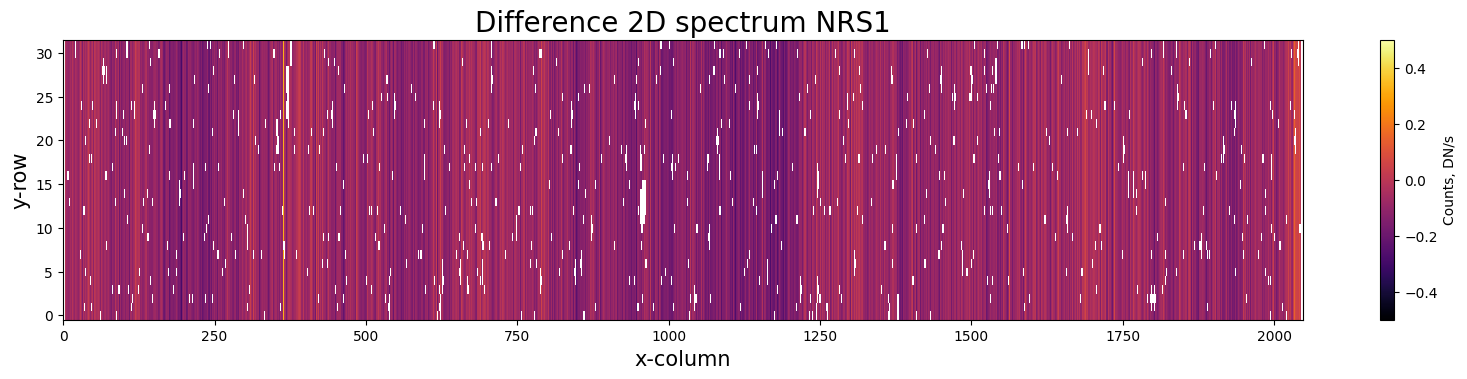

In [9]:
if process_detector == "nrs1":
    int_id = 100  # select an integration to show
    f_lo = -0.5  # lower limit for flux
    f_hi = +0.5  # upper limit for flux

if process_detector == "nrs2":
    int_id = 0  # select an integration to show
    f_lo = -0.5  # lower limit for flux
    f_hi = +0.5  # upper limit for flux

# Plot the original uncorrected image
plt.figure(figsize=(20, 8))
plt.subplot(211)
plt.title("Uncorrected 2D spectrum " + process_detector.upper(), fontsize=20)
im1 = plt.imshow(
    ramp_sci[int_id, :, :],
    interpolation="None",
    aspect="auto",
    cmap="inferno",
    origin="lower",
    clim=(f_lo, f_hi),
)

plt.xlabel("x-column", fontsize=15)
plt.ylabel("y-row", fontsize=15)

cb1 = plt.colorbar(label=r"Counts, DN/s")


# Plot the corrected image
plt.figure(figsize=(20, 8))
plt.subplot(211)
plt.title("1/f-corrected 2D spectrum " + process_detector.upper(), fontsize=20)
im1 = plt.imshow(
    corrected_1overf_2Dspec[int_id, :, :],
    interpolation="None",
    aspect="auto",
    cmap="inferno",
    origin="lower",
    clim=(f_lo, f_hi),
)

plt.xlabel("x-column", fontsize=15)
plt.ylabel("y-row", fontsize=15)

cb1 = plt.colorbar(label=r"Counts, DN/s")


# Plot the difference image
plt.figure(figsize=(20, 8))
plt.subplot(211)
plt.title("Difference 2D spectrum " + process_detector.upper(), fontsize=20)
im1 = plt.imshow(
    ramp_sci[int_id, :, :] - corrected_1overf_2Dspec[int_id, :, :],
    interpolation="None",
    aspect="auto",
    cmap="inferno",
    origin="lower",
    clim=(f_lo, f_hi),
)

plt.xlabel("x-column", fontsize=15)
plt.ylabel("y-row", fontsize=15)

cb1 = plt.colorbar(label=r"Counts, DN/s")

plt.show()

The 1/f-correction looks good with no significant residual signal as shown by a visual inspection of the difference image.

Finally, we modify the parameter reference file of the `extract_1d` step. We would like to specify the width of the extraction aperture and enable other useful parameters detailed in the next cell. This and several additional parameter reference files are located in the `CRDS_PATH` directory. One can modify "by hand" some of them, such as `.json` files. We opt to modify using Python, which is demonstrated in the cell below.

In [10]:
# import json

json_name = "jwst_nirspec_extract1d_0006.json"
json_dir = os.environ["CRDS_PATH"] + "/references/jwst/nirspec/"

# open file in read-mode
with open(json_dir + json_name, "r") as file:
    # read JSON data
    data = json.load(file)
    if process_detector == "nrs1":
        data["apertures"][0][
            "extract_width"
        ] = 6  # extraction aperture radius in pixels
        data["apertures"][0]["xstart"] = 100  # lower x-index
    if process_detector == "nrs2":
        data["apertures"][0][
            "extract_width"
        ] = 27  # extraction aperture radius in pixels
    #    data['apertures'][0]['xstop'] = 300 # upper x-index
    #    data['apertures'][0]['ystart'] = 5
    #    data['apertures'][0]['ystop'] = 25
    #    data['apertures'][0]['nod2_offset'] = 0 # apply no offsets
    data["apertures"][0].pop("nod2_offset")  # remove
    #    data['apertures'][0]['nod3_offset'] = 0
    data["apertures"][0].pop("nod3_offset")  # remove
    # data['apertures'][0]['nod5_offset'] = 0
    data["apertures"][0].pop("nod5_offset")  # remove
#    print(data['apertures'][0]['extract_width'])

newData = json.dumps(data, indent=4)
# print(json_name[:-5])
with open(
    json_dir + json_name[:-5] + "_bots.json", "w"
) as file:  # '_bots' distinguishes this file from the default.
    # write
    file.write(newData)

A dictionary is defined for all parameters with all steps that are executed by default. We opt to skip the `flat_field` and `photom` steps. These two can introduce scatter in the final light curves because of uncertainty of the small number of flat field frames used to produce the flat field reference file and uncertainty in the throughput used for converting the extracted spectra from relative to absolute units.

The runtime of the `Spec2` step takes approximately 6 minutes for all segments.

In [12]:
param_stage2 = {
    "assign_wcs": {"skip": False},  # Assigns wavelength solution for spectra
    "extract_2d": {"skip": False},  # Obtains 2D cutouts
    "srctype": {"skip": False},  # Assigns source type: 'point' or 'extended'
    "flat_field": {
        "skip": True
    },  # Skip this step, because it can increase the light curve scatter
    "photom": {"skip": True},  # Skip this; BOTS observations are relative
    "pixel_replace": {
        "skip": False,
        "n_adjacent_cols": 5,
        "algorithm": "fit_profile",
    },  # , 'algorithm':'mingrad'
    "extract_1d": {
        "skip": False,
        "override_extract1d": f"{json_dir + json_name[:-5]}_bots.json",
        "apply_apcorr": False,
        "subtract_background": False,
    },  # 'dispaxis': 1, 'xstart': 100, 'xstop': 150, 'extract_width': 10},
}

start = tt.time()

for i in range(len(files)):
    Spec2Pipeline.call(
        stage1_dir + froot[i] + "rateints_1cl.fits",
        save_results=True,
        steps=param_stage2,
        output_dir=stage2_dir,
    )

end = tt.time()
print("Run time: ", round(end - start, 1) / 60.0, " min")

2024-04-05 10:57:48,789 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-04-05 10:57:48,806 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2024-04-05 10:57:48,810 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/nnikolov/Documents/Functional/crds_cache/jwst_ops/references/jwst/nirspec/jwst_nirspec_pars-spec2pipeline_0022.asdf
2024-04-05 10:57:48,840 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-04-05 10:57:48,841 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-04-05 10:57:48,841 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-04-05 10:57:48,842 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-04-05 10:57:48,843 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-04-05 1

Run time:  6.793333333333334  min


#### [Link to the Table of contents](#table)
#### [Link to Spec2](#stage2)

With the second stage of the pipeline executed, we now have extracted spectra to plot and visually inspect. We read the spectra from the x1dints data cube as a data model. The later represent the data in FITS extensions and meta data in FITS headers in a Python object with a tree-like structure. For more information, please consult <a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/user_documentation/datamodels.html">jwst-pipeline.readthedocs.</a>

Once a data cube is read using data models, one can inspect the full contents using the command *.info(), as shown below. Some data models can contain many extensions, which can make their tree-like structure quite long. To limit down to a certain number of values, we can specify the maximum number of values to be printed by including `max_rows=N`, where N is an integer.

In [15]:
x1d = datamodels.open(stage2_dir + froot[0] + "rateints_1cl_x1dints.fits")

# x1d.info(max_rows=None) # prints the full contents
x1d.info(max_rows=10)
# print(x1d)

# Obtain the wavelength and flux from 1d spectral products
x1d_wave = x1d.spec[0].spec_table.WAVELENGTH
x1d_flux = x1d.spec[0].spec_table.FLUX


wave_um = x1d_wave
all_times = x1d.int_times.int_mid_BJD_TDB
# print(len(all_times))

n_spec = len(x1d.spec)
n_pix = len(x1d.spec[0].spec_table.FLUX)
# print(n_spec)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ └─3 not shown
├─history (dict) ...
├─_fits_hash (str): 5365c818960b6876b9de629b3e4397001a4c9786918556f042ab76ee205d51b3
├─int_times (FITS_rec): shape=(155,), dtype=void416
├─meta (dict) ...
└─spec (list) ...
Some nodes not shown.


Next, we will load all of the extracted spectra and time stamps in one big array for easier analysis and plotting.

In [16]:
# Obtain all spectra for the list of segments
for i in range(len(froot)):
    print(
        "Processing segment: ",
        i + 1,
        " out of ",
        len(froot),
        ": ",
        froot[i] + "rateints_1cl_x1dints.fits",
    )
    x1d = datamodels.open(stage2_dir + froot[i] + "rateints_1cl_x1dints.fits")

    n_spec = len(x1d.spec)
    n_pix = len(x1d.spec[i].spec_table.FLUX)

    seg_spec_1D = np.zeros([n_spec, n_pix])

    for j in range(len(x1d.spec)):
        seg_spec_1D[j, :] = x1d.spec[j].spec_table.FLUX

    if i == 0:
        all_spec_1D = seg_spec_1D
        all_times = x1d.int_times.int_mid_BJD_TDB
    if i > 0:
        all_spec_1D = np.concatenate((all_spec_1D, seg_spec_1D), axis=0)
        all_times = np.concatenate((all_times, x1d.int_times.int_mid_BJD_TDB), axis=0)


print(" ")
print("Total number of time stamps: ", len(all_times))
print("Total number of 1D spectra:  ", len(all_spec_1D[:, 0]))
print(" ")
print("Total number of columns: ", len(all_spec_1D[0, :]))
print("Total length of wavemap: ", len(wave_um))
print(" ")

# We also trim several columns at the start and end of the spectra.
# These belong to the reference pixels and are marked 'nan'.
print("Trimming first/last 5 reference pixels with nan-values ...")
all_spec_1D = all_spec_1D[:, 5:-5]
wave_um = wave_um[5:-5]

Processing segment:  1  out of  3 :  jw01366003001_04101_00001-seg001_nrs1_rateints_1cl_x1dints.fits
Processing segment:  2  out of  3 :  jw01366003001_04101_00001-seg002_nrs1_rateints_1cl_x1dints.fits
Processing segment:  3  out of  3 :  jw01366003001_04101_00001-seg003_nrs1_rateints_1cl_x1dints.fits
 
Total number of time stamps:  465
Total number of 1D spectra:   465
 
Total number of columns:  1173
Total length of wavemap:  1173
 
Trimming first/last 5 reference pixels with nan-values ...


In the next cell, we plot three one-dimensional spectra from the spectral time series. We also offset two of them by a constant amount to make them easier to distinguish since nearly all of the TSO spectra have the same flux (except reduced flux during a transit or secondary eclipse). 

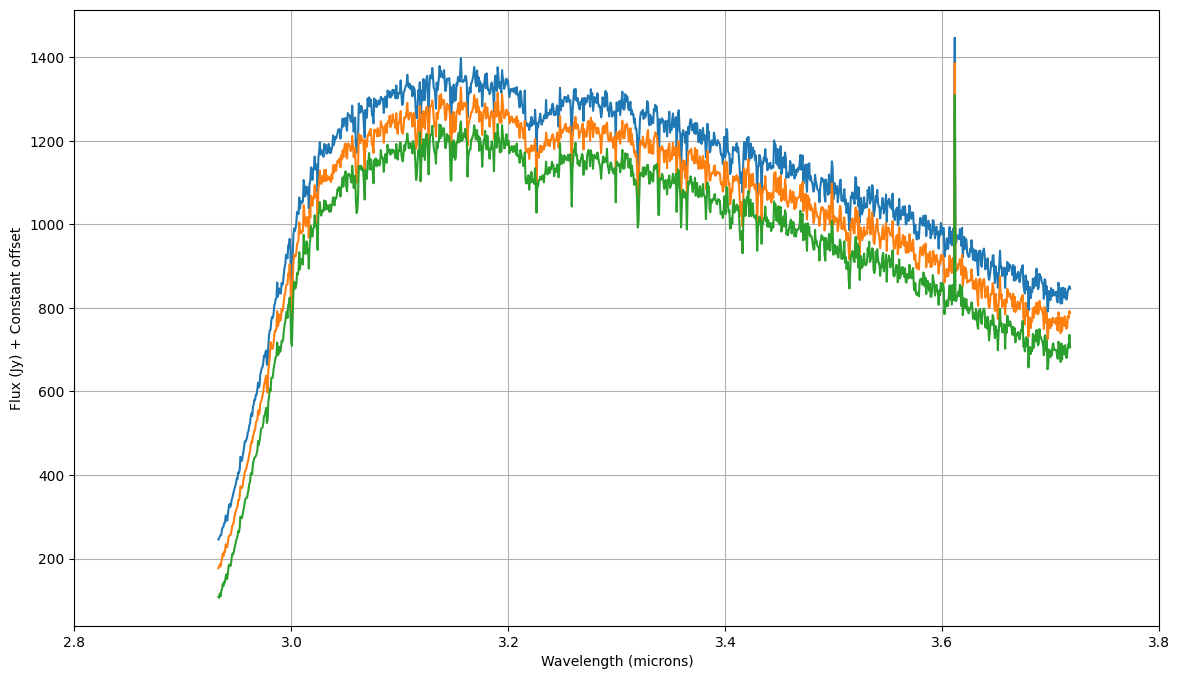

In [17]:
# Plot three spectra from the time series with a constant offset for clarity

fig = plt.figure(figsize=(14, 8))
# plt.plot(x1d_nrs1_wave, x1d_nrs1_flux)
plt.plot(wave_um, all_spec_1D[0, :] - 0.0)
plt.plot(wave_um, all_spec_1D[10, :] - 70.0)
plt.plot(wave_um, all_spec_1D[100, :] - 140.0)

plt.xlabel("Wavelength (microns)")
# plt.yscale('log')
plt.ylabel("Flux (Jy) + Constant offset")

if process_detector == "nrs1":
    plt.xlim(2.8, 3.8)
if process_detector == "nrs2":
    plt.xlim(3.8, 5.2)
# plt.ylim(-0.01,0.04)
plt.grid(True)
plt.show()

Next, we obtain a white light curve by taking the total flux between column 20 and the last column minus 20, and plot the result along with the light curve scatter, measured using the first ~100 data points.

First, we sum the flux from the full wavelength range of each extracted one-dimensional spectrum to produce white light curve. Then we normalize the light curve by dividing the light curve flux to the median flux of the first twenty data points out-of-the-transit. 

In [18]:
n_spec = len(all_times)

# Obtain white light curve
wlc_flux = np.zeros(n_spec)

for i in range(n_spec):
    if process_detector == "nrs1":
        wlc_flux[i] = np.nansum(all_spec_1D[i, 20:-20])
    if process_detector == "nrs2":
        wlc_flux[i] = np.nansum(all_spec_1D[i, 5:-5])

# Normalize by the median flux of the first twenty points
wlc_flux /= np.median(wlc_flux[0:20])

Finally, we plot the light curve to screen and compute and print the light curve scatter using out-of-transit-data.

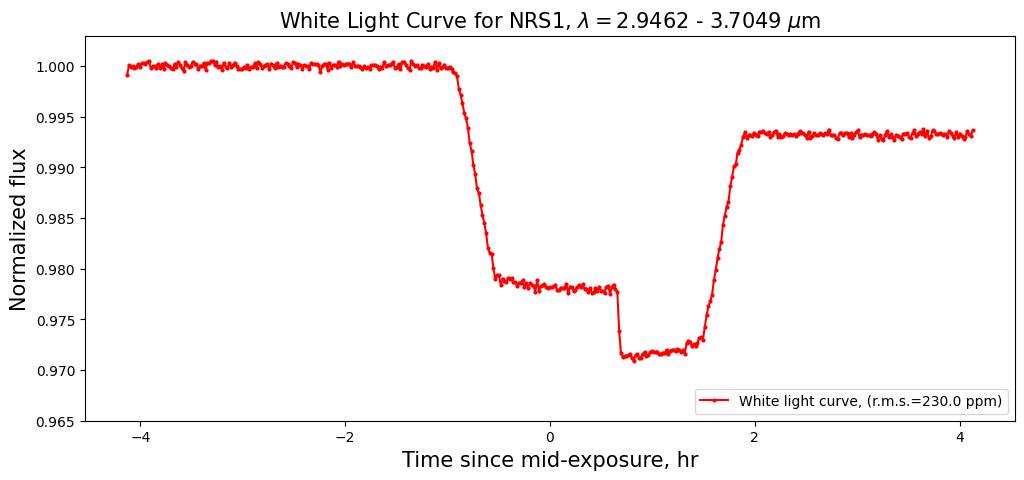

White Light Curve scatter (ppm):   230.0


In [19]:
plt.figure(figsize=(12, 5))
sigma_wlc = np.sqrt(np.nanvar(wlc_flux[2:100]))
plt.plot(
    (all_times - np.nanmean(all_times)) * 24.0,
    wlc_flux,
    color="red",
    marker="o",
    markersize=2,
    label=f"White light curve, (r.m.s.={round(sigma_wlc*1e6, 0)} ppm)",
)
plt.legend(loc="lower right")
plt.title(
    "White Light Curve for "
    + process_detector.upper()
    + rf", $\lambda=${round(wave_um[20], 4)} - {round(wave_um[-20], 4)} $\mu$m",
    fontsize=15,
)
plt.xlabel("Time since mid-exposure, hr", fontsize=15)
plt.ylabel("Normalized flux", fontsize=15)
# plt.xlim([1, nintegrations])
if process_detector == "nrs1":
    plt.ylim([0.965, 1.003])
if process_detector == "nrs2":
    plt.ylim([0.965, 1.015])
# plt.xlim([-4.2,-0.5])

plt.show()

print("White Light Curve scatter (ppm):  ", round(sigma_wlc * 1e6, 0))

The white light curve shows relatively low scatter (230 and 548 ppm for NRS1 and NRS2, respectively) and exhibits the morphology of a transit event along with a step-function flux jump near the mid-transit. This flux jump (a decrease of flux in this case) is attributed to a 'tilt' event, associated with one of the segments of the JWST mirror. A 'tilt' event is considered any uncommanded change in the tip tilt orientation of a mirror segment, and can be caused by a micrometeorite impact. For further details, please consult the following page: <a href="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources">JWST TSO noise sources.</a> 

While the white light curve provides information regarding the overall quality of the data, it is the light curves from each pixel (wavelength) that contains information for the atmosphere of a transiting exoplanet. The next cell demonstrates how such chromatic light curves (also known as wavelength map) can be obtained. 

First, we obtain a copy of all spectra and normalize each spectrum by its mean value. Then we correct for the tilt event by renormalizing the post tilt event light curves. To do that, we divide these light curves by the mean out-of-transit post tilt event flux. 

In [20]:
lc_map = np.copy(all_spec_1D)
#
spec_xlen = len(lc_map[0, :])


correct_tilt_event = "yes"

for j in range(spec_xlen):
    # Normalize each spectrum by the mean
    lc_map[:, j] /= np.nanmean(lc_map[0:170, j])
    if correct_tilt_event == "yes":
        # Correct for tilt event
        lc_map[270:, j] /= np.nanmean(lc_map[330:460, j])

Finally, we plot the resulting wavelength map. The cell above can be rerun without correction for the tilt event. In this case, all light curves after the tilt event will look offset by a constant amount owing to the redistributed wavefront. 

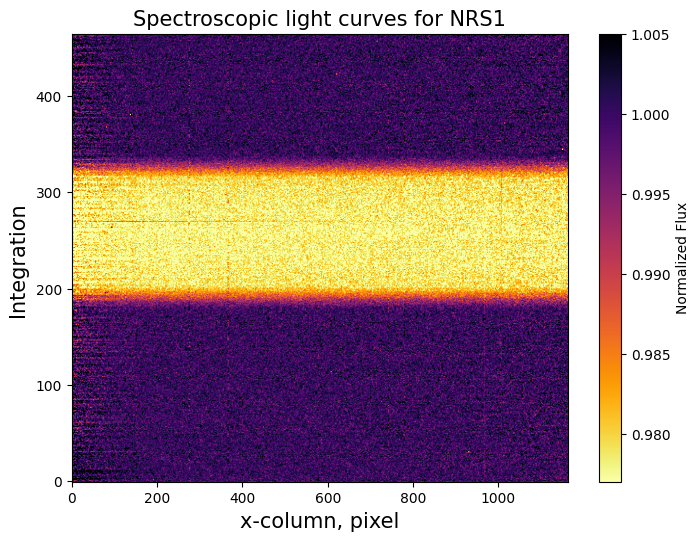

In [21]:
mfactor = 1.6
plt.figure(figsize=(5 * mfactor, 8 * mfactor))
plt.subplot(211)
plt.title("Spectroscopic light curves for " + process_detector.upper(), fontsize=15)
im1 = plt.imshow(
    lc_map,
    interpolation="bilinear",
    aspect="auto",
    cmap="inferno_r",
    origin="lower",
    clim=(0.977, 1.005),
)

plt.xlabel(r"x-column, pixel", fontsize=15)
plt.ylabel("Integration ", fontsize=15)

cb1 = plt.colorbar(label=r"Normalized Flux")

plt.show()

The plot above shows all extracted 1d spectra covering the transit event. The horizontal axis is the spectral direction (wavelength) and the vertical - each integration (time). The dark pixels correspond to the out-of-transit data (pre/post transit), the orange horizontal stripes indicate the ingress and egress portions, and the yellow stripe shows the in-transit part of the light curve. Please note, we have corrected the tilt event data by normalizing all spectra after integration 330 using the post transit flux. 

We now have white and spectroscopic light curves, which are ready for fitting (not covered in this notebook). In case there is a need to identify spectral trace and obtain centroid information for the time series, please consult the following notebook that offers workaround solutions for Spec2 with additional analysis and features, presented on a JWebbinar in December 2023: <a href="https://github.com/exonik/JWebbinar2023-TSO/blob/main/Part2-Spec2.ipynb">Part2-Spec2.ipynb</a> 

It should be pointed out that the workaround solutions lead to a lower white light curve scatter for this particular data set (approximately 70 ppm lower, or 160ppm for NRS1). The difference is determined by two factors: 
1. The pixel replacement step in the workaround makes use of a nominal psf profile constructed from adjacent columns (of a column that needs to be corrected) to identify high and low pixels in addition to the data quality flags, and 
2. At the time of writing the spectral resampling step is unavailable in the STScI pipeline. Instead, in the workaround notebook, we fit for the centroid of the star to locate and trace the spectra (without resampling) and perform aperture extraction using the trace.

The rest of this notebook demonstrates how to rerun the third and final stage of the STScI pipeline, which extracts the spectra (yes, again) and produces a white light curve, which we already did.

#### [Link to the Table of contents](#table)
#### [Link to Stage 1](#stage1), [Link to Stage 2](#stage2)

---
### <font color='white'>-</font>Stage 3: Tso3Pipeline<a class="anchor" id="stage3"></a>

---

The stage3 TSO pipeline is applied to associations (`.json` files) of calibrated BOTS exposures and produces calibrated spectra and white light curve of the source object. For details, please consult  <a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_tso3.html">calwebb_tso3: Stage 3 Time-Series Observation(TSO) Processing.</a>

To be able to run the `TSO3Pipeline`, we need to modify the association file to have only the science exposures of the detector we analyze. We need to exclude the target acquisition exposures (TAs) from the members of the association. The next cell performs this task.


In [22]:
# open file in read-mode
with open(stage2_dir + asn_spec3_file, "r") as file:
    # read JSON data
    data = json.load(file)

# Print json contents to screen
# print(json.dumps(data, indent=2))


for i in range(len(data["products"][0]["members"])):

    # Rename the members to match the filenames of the 1/f - corrected files
    data["products"][0]["members"][i]["expname"] = (
        data["products"][0]["members"][i]["expname"][0:38] + "rateints_1cl_calints.fits"
    )


# Delete file names that are not needed e.g., TA exposures.
if process_detector == "nrs1":
    del data["products"][0]["members"][7]
    del data["products"][0]["members"][6]
    del data["products"][0]["members"][5]
    del data["products"][0]["members"][3]
    del data["products"][0]["members"][1]

if process_detector == "nrs2":
    del data["products"][0]["members"][7]
    del data["products"][0]["members"][6]
    del data["products"][0]["members"][4]
    del data["products"][0]["members"][2]
    del data["products"][0]["members"][0]


# Save the modified association as a new file
newData = json.dumps(data, indent=4)
with open(
    stage2_dir + asn_spec3_file[:-5] + "_" + process_detector + ".json", "w"
) as file:  # add the suffix '_bots' to distinguish the file from the default version.
    # write
    file.write(newData)

We will once again modify the `extract_1d` parameter reference file to adjust the size of extracting aperture. This is needed, because the pipeline currently does not resample the 2D spectra to rectify the spectra (remove the curvature). We therefore rely on a wide extraction aperture and provide the 1/f-noise corrected 2D spectra. 

In [23]:
json_name = "jwst_nirspec_extract1d_0006.json"
json_dir = os.environ["CRDS_PATH"] + "/references/jwst/nirspec/"

# open file in read-mode
with open(json_dir + json_name, "r") as file:
    # read JSON data
    data = json.load(file)
    if process_detector == "nrs1":
        data["apertures"][0][
            "extract_width"
        ] = 6  # extraction aperture radius in pixels
        data["apertures"][0]["xstart"] = 100  # lower x-index
    if process_detector == "nrs2":
        data["apertures"][0][
            "extract_width"
        ] = 27  # extraction aperture radius in pixels
    data["apertures"][0].pop("nod2_offset")  # remove
    data["apertures"][0].pop("nod3_offset")  # remove
    data["apertures"][0].pop("nod5_offset")  # remove

newData = json.dumps(data, indent=4)
with open(
    json_dir + json_name[:-5] + "_bots.json", "w"
) as file:  # add the suffix '_bots' to distinguish the file from the default version.
    # write
    file.write(newData)

In [24]:
# from jwst.pipeline import Tso3Pipeline

By default, the pipeline will perform an `outlier_detection` and repeat spectral extraction, this time on the `cleaned` spectra. This workflow has been envisioned for spectral data from all JWST instruments. While the `outlier_detection` step could provide adequate corrections for non-TSO spectra, this is not the case for BOTS. We therefore opt to skip this step and repeat spectral extraction. It should be noted that in this case, the User can simply copy the extracted spectra from `Spec2Pipeline` and proceed with the `white_light` step. 

This step takes about 2.5 minutes to run.

In [25]:
param_stage3 = {
    "outlier_detection": {"skip": True},
    "extract_1d": {
        "skip": False,
        "override_extract1d": f"{json_dir + json_name[:-5]}_bots.json",
        "apply_apcorr": False,
        "subtract_background": False,
    },  # 'dispaxis': 1, 'xstart': 100, 'xstop': 150, 'extract_width': 10},
    "white_light": {"skip": False},
}


start = tt.time()

Tso3Pipeline.call(
    stage2_dir + asn_spec3_file[:-5] + "_" + process_detector + ".json",
    save_results=True,
    steps=param_stage3,
    output_dir=stage3_dir,
)

end = tt.time()
print("Run time: ", round(end - start, 1) / 60.0, " min")

2024-04-05 11:37:30,755 - CRDS - ERROR -  Error determining best reference for 'pars-whitelightstep'  =   No match found.
2024-04-05 11:37:30,759 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.
2024-04-05 11:37:30,760 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2024-04-05 11:37:30,761 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.
2024-04-05 11:37:30,762 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2024-04-05 11:37:30,763 - stpipe.Tso3Pipeline.photom - INFO - PhotomStep instance created.
2024-04-05 11:37:30,764 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.
2024-04-05 11:37:30,882 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline running with args ('/Users/nnikolov/Documents/Functional/NIRSpec/Pipeline_testing/20231211_NB_for_MClarke/stage2/jw01366-o003_20230901t213306_tso3_00001_asn_nrs1.json',).
2024-04-05 11:37:30,885 - stpipe.Tso3Pipe

Run time:  2.2916666666666665  min


#### [Link to the Table of contents](#table)
#### [Link to Stage 1](#stage1), [Link to Stage 2](#stage2), [Link to Stage 3](#stage3)

Finally, read and plot the white light curve from the `.csv` file

sigma:  229.19297621021357


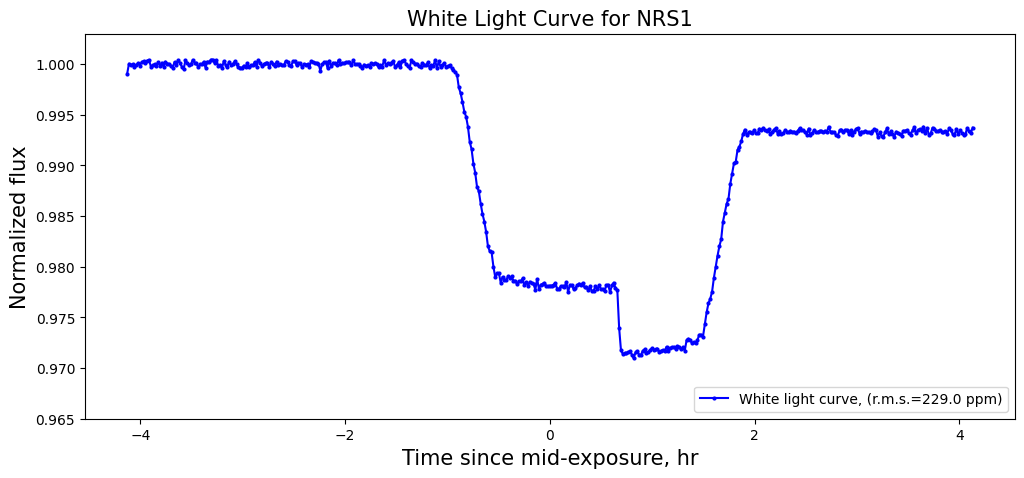

White Light Curve scatter (ppm):   229.0


In [26]:
# Read the white light curve as an Astropy table
schema = {"data": "2D float64"}

data = Table.read(
    stage3_dir + "jw01366-o003_t001_nirspec_f290lp-g395h-s1600a1-sub2048_whtlt.ecsv",
    format="ascii.ecsv",
    converters=schema,
)

tx = data["MJD"]
ty = data["whitelight_flux"]

xx = np.zeros(len(tx))
yy = np.zeros(len(tx))

for i in range(len(tx)):
    xx[i] = tx[i]
    yy[i] = ty[i]
    # print(tx[i])

yy = yy / np.median(yy[0:100])

print("sigma: ", np.std(yy[2:100]) * 1e6)


plt.figure(figsize=(12, 5))
sigma_wlc = np.sqrt(np.nanvar(yy[2:100]))
plt.plot(
    (xx - np.nanmean(xx)) * 24.0,
    yy,
    color="blue",
    marker="o",
    markersize=2,
    label=f"White light curve, (r.m.s.={round(sigma_wlc*1e6, 0)} ppm)",
)
plt.legend(loc="lower right")
plt.title("White Light Curve for " + process_detector.upper(), fontsize=15)
plt.xlabel("Time since mid-exposure, hr", fontsize=15)
plt.ylabel("Normalized flux", fontsize=15)
# plt.xlim([1, nintegrations])
if process_detector == "nrs1":
    plt.ylim([0.965, 1.003])
if process_detector == "nrs2":
    plt.ylim([0.965, 1.015])
# plt.xlim([-4.2,-0.5])

plt.show()

print("White Light Curve scatter (ppm):  ", round(sigma_wlc * 1e6, 0))

---

### <font color='white'>-</font>5. Concluding remarks<a class="anchor" id="remarks"></a>

---


In this notebook, we demonstrated how to obtain white and spectroscopic light curves by (re-) running the three stages of the JWST pipeline and our custom steps. The saved data producs can now be provided to light curve fitting codes for measurements of the physical properties of the exoplanet (or other source with temporal variability) and obtaining a transmission spectrum. It should be pointed out that the analyses performed here are only a subset of the possible analyses one can perform, and are in no way the final word on _how_ JWST data _should_ be analyzed. This will be solidified more and more as data comes and best practices are established in the current and future cycles.

In conclusion, I would like to express my gratitude to the entire JWST team that has supported the creation of this notebook through discussions and testing, which have improved the notebook. In particular, special thanks to the Time-Series Observations Working Group at STScI, including Néstor Espinoza, Leonardo Ubeda, Sarah Kendrew, Elena Manjavacas, Brian Brooks, Mike Reagan, Loïc Albert, Everett Schlawin, Stephan Birkmann among others. To the NIRCam IDT team for multiple fruitful discussions, including Everett Schlawin, Thomas Beatty, Tom Greene and Jarron Leisenring. To the ERS Transiting Exoplanet team who have provided several venues for discussion and community input. To the several JWST team members, including behind the pipeline and the mission itself, including and in no particular order Bryan Hilbert, Armin Rest, Anton Koekemoer, Alicia Canipe, Melanie Clarke, James Muzerolle, Kayli Glidic, Jeff Valenti and Karl Gordon. 

#### [Link to the Table of contents](#table)
#### [Link to Stage 1](#stage1), [Link to Stage 2](#stage2), [Link to Stage 3](#stage3)